Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [ ]:
NAME = ""
COLLABORATORS = ""

---

# Vaja 7: Prileganje 3D modelov na 2D slike

## Navodila
Prileganje 3D modelov ali slik objekta zanimanja na 2D slike omogoča določanje položaja teh objektov v 3D prostoru. Postopek prileganja 3D modela na 2D sliko imenujemo **3D-2D poravnava**. 3D-2D poravnava je proces iskanja optimalne geometrijske preslikave $\mathcal{T}: \mathbb{R}^3 \rightarrow \mathbb{R}^3$, ki 3D model oz. sliko $V$ nekega objekta preslika v tako lego, ki je *skladna* s projekcijo istega objekta na zajeti 2D sliki $P$. Glavni izziv pri poravnavi 3D in 2D slik je prostorska neskladnost slikovne informacije (3D vs. 2D), ki jo lahko odpravimo na dva načina: 
1. **s projekcijo 3D informacije v 2D slikovni prostor** ali 
2. z rekonstrukcijo 3D slike iz različnih 2D projekcij.

Pri vaji boste načrtali postopek poravnave s projekcijo 3D slike v 2D ($\mathcal{P}: \mathbb{R}^3 \rightarrow \mathbb{R}^2$) in maksimizacijo mere podobnosti $MP$ med projekcijo $\mathcal{P}(V)$ in 2D sliko $P$. Način projekcije zavisi od oblike 3D informacije. Pri vaji bo dana 3D CT (CT -- ang. Computed Tomography) slika, v kateri vsak slikovni element predstavlja atenuacijski koeficient $\mu(\mathbf{x})$ zajete 3D scene. Za potrebe poravnave 3D in 2D slik boste s pomočjo 3D CT slike simulirali 2D rentgenske slike, pri katerih se projekcija iz 3D prostora v 2D sliko izraža kot integral atenuacijskega koeficienta vzdolž premice od izvora rentgenskih žarkov $S$ do 2D slikovne ravnine $P = \int_l \mu(l) dl$. Tovrstno projekcijo 3D CT slike imenujemo digitalno rekonstruirani rentgenski posnetek (DRR -- ang. Digitally Reconstructed Radiograph). Projekcija in pripadajoče količine so prikazane na spodnji sliki.

![3D2D Poravnava](images/RV_8_SLO_3D2DPoravnava.png)  

Prostorsko ujemanje med projekcijo $\mathcal{P}(V)$ in 2D sliko $P$ ovrednotimo z mero podobnosti $MP$; to je skalarna funkcija, ki zavzame maksimum, ko se položaji korespondenčnih struktur v $\mathcal{P}(V)$ in $P$ medsebojno prekrivajo. Mero podobnosti je potrebno smiselno izbrati, tako da je čim manj občutljiva na motilna slikovna neskladja in čim bolj občutljiva na dejanska geometrijska neskladja med slikama. Za poravnavo monomodalnih slik, pri katerih običajno velja predpostavka o linearni zvezi med intenzitetami slik v poravnavi, se pogosto uporablja **korelacijski koeficient** $CC$ (CC -- ang. Correlaction Coefficient), ki je definiran kot:

$$
    CC(I, J) = \frac{\sum_{i=1}^{N}\sum_{j=1}^{M} (I(x_i, y_j) - \overline{I}) \cdot (J(x_i, y_j) - \overline{J})}{\sqrt{\sum_{i=1}^{N}\sum_{j=1}^{M} (I(x_i, y_j) - \overline{I})^2 \sum_{i=1}^{N}\sum_{j=1}^{M} (J(x_i, y_j) - \overline{J})^2}}\,,
$$

kjer $N$ in $M$ predstavljata število elementov vzdolž $x$ in $y$ osi slike. 

Za poravnavo večmodalnih slik, tj. slik ki so zajete z različnimi napravami in v katerih so zveze med intenzitetami slik v poravnavi lahko le statistične, se pogosto uporabljata **medsebojna informacija** $MI$ (MI -- ang. Mutual Information):

$$
    MI(I,J) = H(I) + H(J) - H(I,J) \,,
$$

kjer sta $H(I)$ in $H(J)$ entropija referenčne $I(x,y)$ in lebdeče $J(x,y)$ slike, $H(I,J)$ pa njuna skupna entropija: 

$$
  \begin{split}
    H(I) &= - \sum_{s_I=0}^{L-1} p_I(s_I) \log p_I(s_I)\,,\\
    H(J) &= - \sum_{s_J=0}^{L-1} p_J(s_J) \log p_J(s_J)\,,\\
    H(I,J) &= - \sum_{s_I=0}^{L-1}\sum_{s_J=0}^{L-1} p_{IJ}(s_I,s_J) \log p_{IJ}(s_I,s_J)\,,\\
  \end{split}
$$

kjer spremenljivki $s_I$ in $s_J$ označujeta soležne, diskretne sivinske vrednosti referenčne slike $I(x,y)$ in lebdeče slike $J(x,y)$, $L$ pa število diskretnih vrednosti. Verjetnostni porazdelitvi $p_I(s_I)$ in $p_J(s_J)$ ter skupno porazdelitev $p_{IJ}(s_I,s_J)$ dobimo iz pripadajočih normaliziranih histogramov $h_I(s_I)$, $h_J(s_J)$ ter $h_{IJ}(s_I,s_J)$:

$$
  p_I(s_I) = \frac{h_I(s_I)}{N\cdot M}\,,\quad
  p_J(s_J) = \frac{h_J(s_J)}{N\cdot M}\,,\quad
  p_{IJ}(s_I,s_J) = \frac{h_{IJ}(s_I,s_J)}{N\cdot M}\,,
$$

kjer $N$ in $M$ predstavljata število elementov vzdolž $x$ in $y$ osi slike.

Tekom poravnave 3D in 2D slike nam izbrana optimizacijska metoda iterativno spreminja parametre $\mathbf{p}$ geometrijske preslikave $\mathcal{T} = \mathcal{T}(\mathbf{p})$ tako, da maksimizira mero podobnosti: 

$$
  \mathbf{p}^* = \mathrm{argmax}_\mathbf{p} \, MP\Bigl( \mathcal{P}\bigl( V[ \mathcal{T}(\mathbf{p}) ]\bigr), P \Bigr) \,,
$$

kjer so $\mathbf{p}^*$ optimalni parametri preslikave $\mathcal{T}(\mathbf{p})$. Za poravnavo 3D in 2D slik vretenc boste uporabili togo preslikavo, ki je v 3D definirana s šestimi parametri $\mathbf{p}=[t_x, t_y, t_z, \alpha, \beta, \gamma]^{\mathrm{T}}$. Postopek poravnave 3D in 2D slik je prikazan na gornji sliki.

## Naloge
**Gradivo** za vajo v datoteki `data/vretenca.npz` vsebuje dve 3D CT sliki in eno 2D rentgensko sliko. Datoteko naložite z ukazom `numpy.load()`, z branjem lastnosti `files` pa lahko preverite imena vsebovanih spremenljivk. Vse spremenljivke so dane v obliki `numpy` polja. V spremenljivkah `ctVol` in `ct2Vol` ter `xrayImg` so dane pripadajoče 3D in 2D matrike sivinskih vrednosti, v spremenljivkah `ctTPos`, `ct2TPos` in `xrayTPos` geometrijske preslikave koordinatnih sistemov 3D in 2D slik iz referenčnega koordinatnega sistema v prvi slikovni element slike z indeksom `[0, 0, 0]` oziroma `[0, 0]`, v spremenljivki `xraySPos` pa položaj izvora rentgenskih žarkov v referenčnem koordinatnem sistemu. Korak vzorčenja 3D in 2D slik je 1 milimeter. Geometrijske razmere in količine so ponazorjene v gornji sliki. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import rvlib

from scipy.optimize import fmin, minimize
from scipy.interpolate import interpn
import scipy.ndimage as ni
from mpl_toolkits.mplot3d import Axes3D

def preprocess_ct(ct):
    ct_temp = dict(ct)
    ct_temp['img'] = (ct_temp['img'] - np.median(ct_temp['img'])).\
           astype('float')
    return ct_temp        

def preprocess_Xray(Xray):
    Xray_temp = dict(Xray)
    Xray_temp['img'] = rvlib.windowImage(Xray_temp['img'], 60.0, 120.0)
    Xray_temp['img'] = Xray_temp['img'].astype('float') / \
             Xray_temp['img'].max() * 255.0
    return Xray_temp

def addHomogCoord(iPts):
    '''
    Seznamu 2D koordinat dodaj homogeno koordinato

    Parameters
    ----------
    iPts : numpy.ndarray
        Polje Nx3 koordinat x, y, z
        
    Returns
    --------
    oPts : numpy.ndarray
        Polje Nx4 homogenih koordinat x, y, z

    '''
    iPts = np.asarray(iPts)
    iPts = np.hstack((iPts, np.ones((iPts.shape[0],1))))
    return iPts

ValueError: shapes (4,3) and (4,1) not aligned: 3 (dim 1) != 4 (dim 0)

1. Za potrebe nadaljnjih nalog za vsako od danih slik ustvarite spremenljivko tipa `dict`, npr. `ct`, `ct2` in `Xray`, in pod ustreznim ključem vnesite sivinske vrednosti slike in pripadajočo preslikavo v referenčnem koordinatnem sistemu (`ctTPos`, `ct2TPos` in `xrayTPos`), za 2D rentgensko sliko pa še položaj izvora rentgenskih žarkov (`xraySPos`).

In [2]:
v = np.load('data/vretenca.npz')
# oblikuj v dict
Xray = {'img': v['xrayImg'], 'TPos': v['xrayTPos'], 'SPos': v['xraySPos']}
ct = {'img': v['ctVol'], 'TPos': v['ctTPos']}
ct2 = {'img': v['ct2Vol'], 'TPos': v['ct2TPos']}#voxel -> 3d pixel

2. Ustvarite vzorčni mreži 2D rentgenske in 3D CT slike s pomočjo ukaza `numpy.meshgrid()`. Točke na vzorčnih mrežah preslikajte v referenčni koordinatni sistem s pripadajočimi 3D togimi preslikavami `Xray.TPos` in `ct.TPos`. Preslikane točke 3D in 2D vzorčnih mrež in položaj izvora rentgenskih žarkov `Xray.SPos` prikažite s pomočjo ukaza `Axes3D.scatter()`. Preverite pravilnost dobljene geometrijske postavitve izvora $S$, 3D in 2D slike v referenčnem koordinatnem sistemu s pomočjo spodnje slike.

![3D Geometrija](images/RV_8_SLO_3DGeometrija.png)

<IPython.core.display.Javascript object>


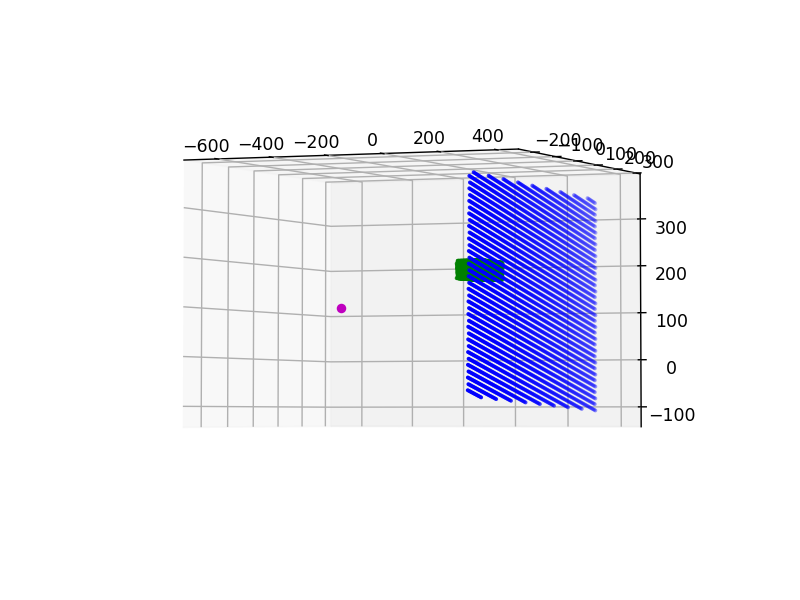

In [4]:
s3z, s3y, s3x = ct['img'].shape
g3x, g3y, g3z = np.meshgrid(range(s3x), range(s3y), range(s3z), indexing='xy')
# ustvari Nx4 matriko, zadnja koordinata homogena
g3 = np.vstack((g3x.flatten(), g3y.flatten(), g3z.flatten())).transpose()
g3 = np.hstack((g3, np.ones((g3.shape[0], 1))))

s2y, s2x = Xray['img'].shape
g2x, g2y = np.meshgrid(range(s2x), range(s2y), indexing='xy')
# ustvari Mx4 matriko, zadnja koordinata homogena
g2 = np.vstack((g2x.flatten(), g2y.flatten())).transpose()
g2 = np.hstack((g2, np.zeros((g2.shape[0], 1)), np.ones((g2.shape[0], 1))))

g3p = np.dot(g3, ct['TPos'].transpose())
g2p = np.dot(g2, Xray['TPos'].transpose())
xsp = Xray['SPos'].flatten()

s2 = 50
s3 = 30

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xsp[0], xsp[1], xsp[2], c='m', marker='o')
ax.scatter(g2p[::s2,0], g2p[::s2,1], g2p[::s2,2], c='b', marker='.', linewidths=0)
ax.scatter(g3p[::s3,0], g3p[::s3,1], g3p[::s3,2], c='g', marker='.', linewidths=0)

In [8]:
# print(g3x)

3. Napišite funkcijo, ki preslika poljubno točko `iPos` v 3D prostoru na 2D slikovno ravnino glede na izvor rentgenskih žarkov $S$ (`xraySPos`):
```python
    def mapPointToPlane( iPos, Xray ):
        return oPos
```
kjer je `iPos` matrika $N \times 3$, `Xray` pa spremenljivka s podatki o 2D rentgenski sliki. Funkcija vrne točke v matriki `oPos` v obliki matrike $N \times 3$. V ravnino preslikane točke izračunate kot presečišča 2D slikovne ravnine s premicami, ki izvirajo v izvoru rentgenskih žarkov in gredo skozi točke `iPos`. Preverite delovanje funkcije tako, da preslikate koordinate oglišč 3D slike na 2D slikovno ravnino in točke vrišete v geometrijsko postavitev iz prejšnje naloge.

In [10]:
def mapPointToPlane(iPos, Xray):
    # tocke so v obliki Nx3/4
    iPos = np.asarray(iPos)
    if iPos.ndim == 1:
        iPos = np.reshape(iPos, (1,iPos.size))    
    iPos = iPos[:,:3]    
    # doloci izhodisce na detektorju
    p0 = np.dot(Xray['TPos'], np.array([0, 0, 0, 1]))
    # doloci normalo na ravnino
    ex = np.dot(Xray['TPos'], np.array([1, 0, 0, 1]))
    ey = np.dot(Xray['TPos'], np.array([0, 1, 0, 1]))
    n = np.cross(ex[:-1] - p0[:-1], ey[:-1] - p0[:-1])    
    #n = np.dot(Xray['TPos'], np.array([0, 0, 1, 0]))    
    n = n / np.sqrt(np.sum(n**2.0))  

    # s = rvlib.addHomo(Xray['SPos'].reshape((1,3)))
    # skrajsaj vse vektorje na dimenzije 1x3
    p0 = p0[:3]
    n = n[:3]
    s = Xray['SPos'].reshape((1,3))
    
    # koeficient za skaliranje smernega vektorja
    alpha = np.dot(p0 - s, n) / np.dot(iPos - s, n)

    # doloci polozaj tock na detektorju
    oPos = s + alpha.reshape((iPos.shape[0],1)) * (iPos - s)
    
    return oPos

<IPython.core.display.Javascript object>


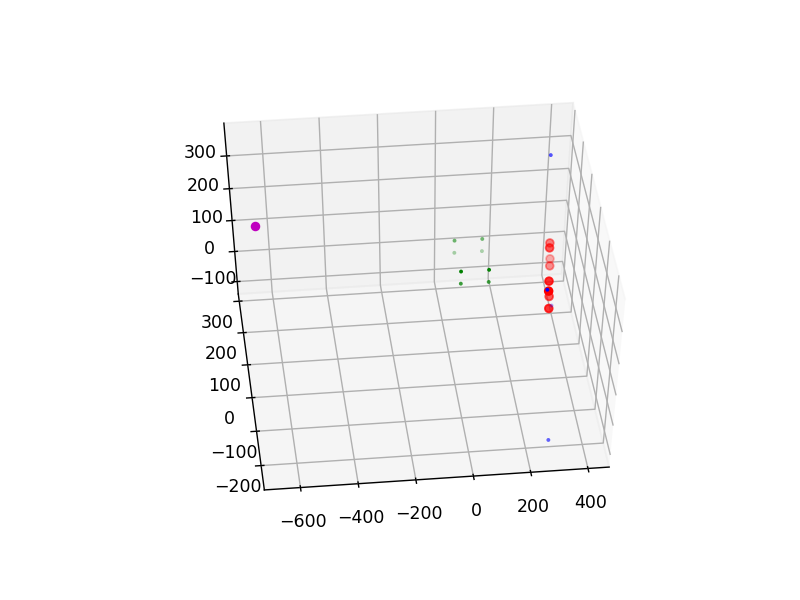

In [11]:
# Testiranje funkcije mapPointToPlane

# ustvari mrezo tock oglisc 3D slike
sz, sy, sx = ct['img'].shape
g3x, g3y, g3z = np.meshgrid((0, sx-1), (0, sy-1), (0, sz-1), indexing='xy')
g3 = np.vstack((g3x.flatten(), g3y.flatten(), g3z.flatten())).transpose()
g3 = np.hstack((g3, np.ones((g3.shape[0], 1))))
g3p = np.dot(g3, ct['TPos'].transpose())    

# ustvari mrezo tock oglisc 2D slike
s2y,s2x = Xray['img'].shape
g2x,g2y = np.meshgrid((0, s2x-1),(0, s2y-1),indexing='xy')
# ustvari Mx4 matriko, zadnja koordinata homogena
g2 = np.vstack((g2x.flatten(), g2y.flatten())).transpose()
g2 = np.hstack((g2, np.zeros((g2.shape[0], 1)), np.ones((g2.shape[0], 1))))
g2p = np.dot(g2, Xray['TPos'].transpose())

# koordinata izvora zarkov
xsp = Xray['SPos'].flatten()    

# tocke 3D oglisc na ravnini detektorja
g2proj = mapPointToPlane(g3p[:,:3], Xray)

# narisi geometrijske razmere
s = 1
fig = plt.figure()    
ax = fig.add_subplot(111,projection='3d')
ax.scatter(xsp[0], xsp[1], xsp[2], c='m', marker='o')
ax.scatter(g2p[::s,0], g2p[::s,1], g2p[::s,2], c='b', marker='.', linewidths=0)
ax.scatter(g3p[::s,0], g3p[::s,1], g3p[::s,2], c='g', marker='.', linewidths=0)
ax.scatter(g2proj[:,0], g2proj[:,1], g2proj[:,2], c='r', marker='o')
# od zgoraj:
# ax.view_init(elev=80, azim=-125)
# iz zornega kota vira
# ax.view_init(elev=-9, azim=147)

#rdece tocke so projekcija

4. Napišite funkcijo za stožčasto projekcijo 3D CT slike v 2D slikovno ravnino, ki simulira delovanje rentgena (DRR):
```python
    def project3DTo2D( ct, Xray, iStep ):
        return oDRR, oMask
```
kjer sta `ct` in `Xray` spremenljivki s podatki o 3D CT in 2D rentgenski sliki, `iStep` pa je korak vzorčenja v **milimetrih** vzdolž vsake premice od izvora rentgenskih žarkov do presečišča z 2D slikovno ravnino. Funkcija vrne 2D DRR sliko v spremenljivki `oDRR` in 2D masko DRR slike v spremenljivki `oMask`, ki imata dimenzije $446\times446$ (enako kot `xrayImg`). 2D maska DRR slike označuje tiste točke 2D slikovne ravnine, za katere premica do izvora rentgenskih žarkov seče 3D CT sliko. Preizkusite delovanje funkcije s pomočjo danih `ct` in `Xray` slik in ustvarite DRR oz. projekcijo 3D CT slike. Preizkusite vpliv dolžine koraka `iStep` na projecirano sliko.

In [12]:
def project3DTo2D(ct, Xray, iStep):
    '''
    Naloga 4: Funkcija za stozcasto projekcijo 3D slike v 2D ravnino

    Parameters
    ----------
    ct : dict
        Podatki o 3D ct sliki in sivinske vrednosti pod ključi TPos in img
    Xray : dict
        Podatki o 2D Xray sliki in sivinske vrednosti pod ključi TPos, SPos in img
    iStep : float
        Korak vzorčenja v mm vzdolž Xray žarkov od izvora do 2D detektorja
    
    Returns
    ---------
    oDRR : numpy.ndarray
        Izhodna iz 3D v 2D prostor preslikana slika, ki simulira rentgen
    oMask : numpy.ndarray
        Maska področja kamor se preslika 3D slika (1-ospredje, 0-ozadje)
    '''
    # ustvari mrezo tock oglisc 3D slike
    s3z, s3y, s3x = ct['img'].shape
    g3x, g3y, g3z = np.meshgrid((0,s3x-1),(0,s3y-1),(0,s3z-1),indexing='xy')
    g3 = np.vstack((g3x.flatten(),g3y.flatten(),g3z.flatten())).transpose()
    g3 = np.hstack((g3, np.ones((g3.shape[0],1))))
    g3p = np.dot(g3, ct['TPos'].transpose())    
    
    # tocke 3D oglisc na ravnini detektorja
    g2proj = mapPointToPlane(g3p[:,:3], Xray)       
   
    # preslikaj v 2D ravnino
    g2plane = np.dot(addHomogCoord(g2proj), \
                np.linalg.inv(Xray['TPos']).transpose()) 
    
    # poisci najmanjsi ocrtan pravokotnik
    xmin = np.floor(np.min(g2plane[:,0]))
    xmax = np.ceil(np.max(g2plane[:,0]))
    ymin = np.floor(np.min(g2plane[:,1]))
    ymax = np.ceil(np.max(g2plane[:,1]))
    
    # preveri ali so tocke znotraj 2D slike
    s2y, s2x = Xray['img'].shape
    xmin = np.max((0,xmin)); xmin = int(np.min((s2x,xmin)))
    xmax = np.max((0,xmax)); xmax = int(np.min((s2x,xmax)))
    ymin = np.max((0,ymin)); ymin = int(np.min((s2y,ymin)))
    ymax = np.max((0,ymax)); ymax = int(np.min((s2y,ymax)))
    
    # definiraj mrezo tock v 2D ravnini
    g2x, g2y = np.meshgrid(range(xmin,xmax), range(ymin,ymax), indexing='xy')
    rectShape = g2x.shape
    
    # ustvari Mx4 matriko, zadnja koordinata homogena
    g2 = np.vstack((g2x.flatten(),g2y.flatten())).transpose()
    g2 = np.hstack((g2, np.zeros((g2.shape[0],1)), np.ones((g2.shape[0],1))))
    g2 = np.dot(g2, Xray['TPos'].transpose())
    
    # preberi pozicijo izvora zarkov
    xsp = Xray['SPos'].flatten().reshape((1,3))
    
    # doloci minimalno in maksimalno razdaljo za vzorcenje
#    d = np.sqrt(np.sum((g3p[:,:3]  - g2proj[:,:3])**2.0, axis=0))
    d = np.sqrt(np.sum((g3p[:,:3]  - xsp)**2.0, axis=1))
    dmin = np.min(d); dmax = np.max(d)
  
    # doloci vzornce tocke vzdolz zarkov    
    ds = np.arange(dmin,dmax,iStep)
    ds = np.reshape(ds, (1,ds.size))    

    # definiraj vzorcne tocke v 3d prostoru
    vs = g2[:,:3] - xsp
    vs = vs / np.sqrt(np.sum(vs**2.0, axis=1)).reshape((vs.shape[0],1))
    
    Nx1 = (vs.shape[0],1)
    px = xsp[0,0] + vs[:,0].reshape(Nx1) * ds
    py = xsp[0,1] + vs[:,1].reshape(Nx1) * ds
    pz = xsp[0,2] + vs[:,2].reshape(Nx1) * ds
    
    # preslikava koordinat v prostor 3D slike   
    Tmat = np.linalg.inv(ct['TPos'])
    pxn = Tmat[0,0]*px + Tmat[0,1]*py + Tmat[0,2]*pz + Tmat[0,3]
    pyn = Tmat[1,0]*px + Tmat[1,1]*py + Tmat[1,2]*pz + Tmat[1,3]
    pzn = Tmat[2,0]*px + Tmat[2,1]*py + Tmat[2,2]*pz + Tmat[2,3]

    # preveri katere koordinate so znotraj 3D slike
    idx = np.where((pxn>=0) & (pxn<s3x) & \
                    (pyn>=0) & (pyn<s3y) & \
                    (pzn>=0) & (pzn<s3z))  

    oRayInterp = np.zeros_like(pxn)    
    pxn = pxn[idx[0],idx[1]]
    pyn = pyn[idx[0],idx[1]]
    pzn = pzn[idx[0],idx[1]]

    # izvedi trilinearno interpolacijo      
    oRayInterp_i = interpn((np.arange(s3z),np.arange(s3y),np.arange(s3x)), \
                  ct['img'].astype('float'), \
                  np.dstack((pzn,pyn,pxn)), \
                  method='linear', bounds_error=False, fill_value=0) 
                      
    oRayInterp[idx[0],idx[1]] = oRayInterp_i               

    # izvedi dejansko operacijo vzdolz zarkov                  
    oRayInterp = np.mean(oRayInterp, axis=1).reshape(rectShape)
    
    # ustvari izhodne spremenljivke        
    oDRR = np.zeros_like(Xray['img']).astype('float')
    oMask = np.zeros_like(Xray['img'])

    oDRR[ymin:ymax, xmin:xmax] = oRayInterp
    oMask[ymin:ymax, xmin:xmax] = 255
    
    return oDRR, oMask

Čas izračuna: 1148.3 ms


<IPython.core.display.Javascript object>


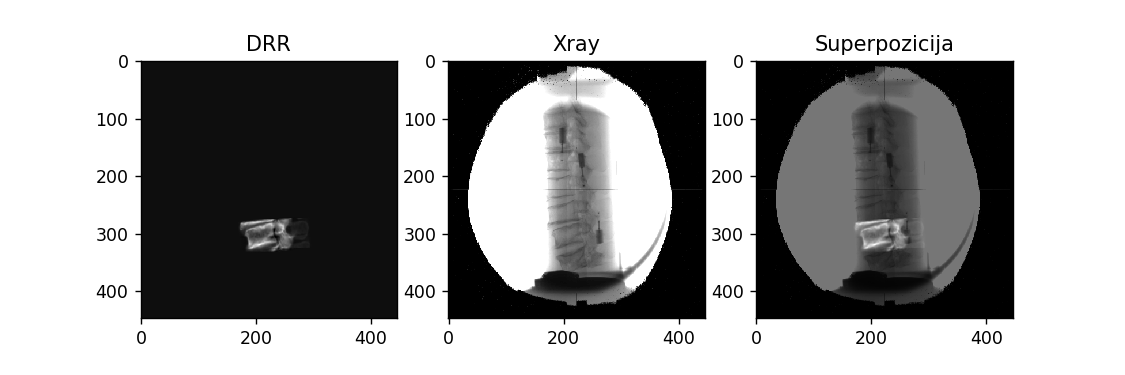

Text(0.5, 1.0, 'Superpozicija')

In [13]:
# Testiranje funkcije project3DTo2D
iStep = 1 

# predobdelava 3D in 2D slik    
ct_temp = preprocess_ct(ct)
Xray_temp = preprocess_Xray(Xray)

ts = time.clock()
oDRR, oDRRMask = project3DTo2D(ct_temp, Xray_temp, iStep)    
print('Čas izračuna: {:.1f} ms'.format(1000.0*(time.clock()-ts)))

# šest osi v enem prikaznem oknu
f, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].imshow(oDRR, cmap='gray')
ax[0].set_title('DRR')
ax[1].imshow(Xray_temp['img'], cmap='gray')
ax[1].set_title('Xray')      
ax[2].imshow(2*rvlib.normalizeImage(oDRR, iType='range') + 
  rvlib.normalizeImage(Xray_temp['img'], iType='range'), cmap='gray')
ax[2].set_title('Superpozicija')

Projekcija 3D slike na 2D ravnino je računsko intenzivna operacija, ki pa jo je možno enostavno paralelizirati. Izračun posamezne intenzitete v projicirani sliki namreč zahteva izračun oz. aproksimacijo integrala 3D slike vzdolž premice, ki povezuje točko v projicirani slik in pa izvor rentgenskih žarkov. Izračun posamezne intenzitete v projicirani sliki torej lahko izvedemo ločeno oz. paralelno za točke, ki tvorijo projicirano sliko. 

Paralelizacijo lahko izvedemo z uporabo **grafične procesne enote** (GPU -- ang. graphical processing unit). Poleg strojne opreme za ta namen uporabljamo posebne programske knjižnice. Pri vaji bomo uporabili programsko knjižnico **CUDA**, ki je napisana v jeziku C/C++ in v kateri napišemo program za izvedbo na GPU, in Python knjižnico **pycuda**, ki omogoča klice programske kode na GPU neposredno iz Python skripte. Spodaj je dana implementacija 3D projekcije z omenjenimi knjižnicami.

Primerjajte dobljene čase projekcije 3D slike med implementacijo s CUDA/pycuda in z implementacijo v Pythonu.

Čas izračuna: 5.8 ms


<IPython.core.display.Javascript object>


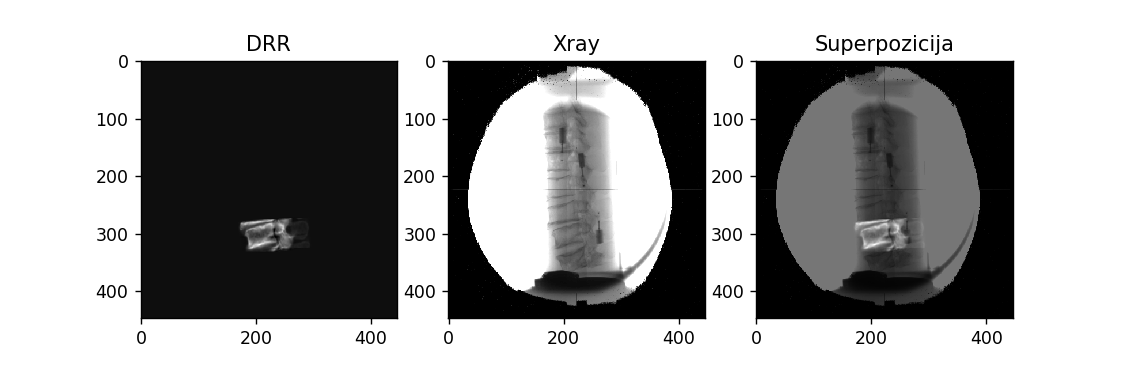

Text(0.5, 1.0, 'Superpozicija')

In [14]:
# Hitra različica projekcije 3D slike z implementacijo CUDA na GPU
import os
from drr import VolumeRenderer

ct_temp = preprocess_ct(ct)
Xray_temp = preprocess_Xray(Xray)
ct_temp.update({'spac': [1.0, 1.0, 1.0]})
Xray_temp.update({'spac': [1.0, 1.0]})
#print(ct_temp)
#print(Xray_temp)

vr = VolumeRenderer(
    vol=ct_temp, 
    img=Xray_temp,
    ray_step_mm=1, 
    render_op='drr'
)

def fast_project3DTo2D(ct, Xray, iStep):
    # rendering for all 2d image pixels
    drr = vr.render(ct['TPos'])
    return drr, drr != 0

ts = time.clock()
oDRR, oDRRMask = fast_project3DTo2D(ct_temp, Xray_temp, iStep)    
print('Čas izračuna: {:.1f} ms'.format(1000.0*(time.clock()-ts)))

# šest osi v enem prikaznem oknu
f, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].imshow(oDRR, cmap='gray')
ax[0].set_title('DRR')
ax[1].imshow(Xray_temp['img'], cmap='gray')
ax[1].set_title('Xray')      
ax[2].imshow(2*rvlib.normalizeImage(oDRR, iType='range') + 
  rvlib.normalizeImage(Xray_temp['img'], iType='range'), cmap='gray')
ax[2].set_title('Superpozicija')

5. Napišite funkcijo za 3D togo preslikavo vzorčne mreže 3D CT slike okoli njenega središča:
```python
    def rigidTrans( ct, iPar ):
        return oTrans
```
kjer vhodna spremenljivka `ct` predstavlja 3D CT sliko, `iPar` pa šestvrstični vektor $\mathbf{p}=[t_x, t_y, t_z, \alpha,$ $\beta, \gamma]^{\mathrm{T}}$ s parametri 3D toge preslikave, kjer so rotacije definirane glede na center 3D slike. Izhodna spremenljivka `oTrans` naj predstavlja togo preslikavo 3D CT slike. 
 
 Razširite funkcijo za 2D projekcijo oz. DRR sliko tako, da bo imela dodatni vhodni parameter `iPar`, npr. `project3DTo2D( ..., iPar )`, kjer je `iPar` je šestvrstični vektor s parametri 3D toge preslikave 3D CT slike okoli njenega središča. Za 3D togo preslikavo 3D CT slike uporabite funkcijo `rigidTrans( ct, iPar )`. Prikažite 2D projekcijske slike za različne vrednosti parametrov preslikave, npr. `iPar = [0 20 0 0 0 0]`, `iPar = [0 0 0 0 45 0]`, `iPar = [0 0 0 0 0 90]`.

In [15]:
def rigidTransMatrix(ct, iPar): # iPar = [tx, ty, tz, alpha, beta, gamma]
    s3z,s3y,s3x = ct['img'].shape
    oRot = rvlib.transAffine3D(iTrans=(0,0,0), iRot=(iPar[3],iPar[4],iPar[5]))
    oTrans = rvlib.transAffine3D(iTrans=(iPar[0],iPar[1],iPar[2]), iRot=(0,0,0))
    oCenter = rvlib.transAffine3D(iTrans=(-s3x/2, -s3y/2, -s3z/2), iRot=(0,0,0))
    oInvCenter = rvlib.transAffine3D(iTrans=(s3x/2, s3y/2, s3z/2), iRot=(0,0,0))
    return np.dot(oTrans, np.dot(oInvCenter, np.dot(oRot, oCenter)))

def project3DTo2D(ct, Xray, iStep, iPar=[0,0,0,0,0,0]):
    TPos = np.dot(ct['TPos'], rigidTransMatrix(ct, iPar))    
    newCt = {'img':ct['img'], 'TPos':TPos}
    #return rvlib.project3DTo2D(newCt, Xray, iStep)
    return fast_project3DTo2D(newCt, Xray, iStep)

Čas izračuna: 36.0 ms


<IPython.core.display.Javascript object>


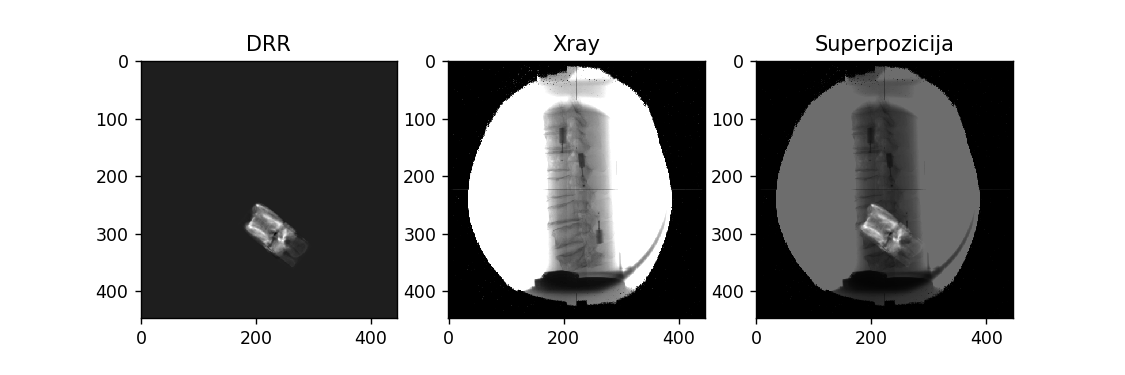

Text(0.5, 1.0, 'Superpozicija')

In [16]:
# test funkcije
# poklici funkcijo
iPar = [0, 0, 0, -45, 0, 0]
iStep = 1

# predobdelava 3D in 2D slik    
ct_temp = preprocess_ct(ct)
Xray_temp = preprocess_Xray(Xray)

ts = time.clock()
oDRR, oDRRMask = project3DTo2D(ct_temp, Xray_temp, iStep, iPar)    
print('Čas izračuna: {:.1f} ms'.format(1000.0*(time.clock() - ts)))

# šest osi v enem prikaznem oknu
f, ax = plt.subplots(1, 3, figsize=(9,3))
ax[0].imshow(oDRR, cmap='gray')
ax[0].set_title('DRR')
ax[1].imshow(Xray_temp['img'], cmap='gray')
ax[1].set_title('Xray')      
ax[2].imshow(2*rvlib.normalizeImage(oDRR, iType='range') + 
  rvlib.normalizeImage(Xray_temp['img'], iType='range'), cmap='gray')
ax[2].set_title('Superpozicija')

6. Napišite funkcijo, ki izračuna vrednost korelacijskega koeficienta med dvema slikama:
```python
    def correlationCoefficient( iImageI, iImageJ ):
        return oMI
```
kjer sta `iImageI` in `iImageJ` 2D sivinski sliki. Funkcija vrne skalar `oCC`, ki predstavlja vrednost korelacijskega koeficienta. Preizkusite delovanje funkcije tako, da izračunate korelacijski koeficient med projicirano sliko in 2D rentgensko sliko. 

Napišite funkcijo, ki izračuna vrednost medsebojne informacije med dvema slikama:
```python
    def mutualInformation( iImageI, iImageJ, iBins ):
        return oMI
```
kjer sta `iImageI` in `iImageJ` 2D sivinski sliki, `iBins` pa število intervalov za izračun histograma. Funkcija vrne skalar `oMI`. Preizkusite delovanje funkcije tako, da izračunate medsebojno informacijo med projicirano sliko in 2D rentgensko sliko, pri tem pa uporabite le sivinske vrednosti na področju maske projicirane slike. Preučite vpliv števila intervalov `iBins` na vrednost medsebojne informacije.

 Izračunajte in izrišite vrednosti `oCC` in `oMI` med 2D projekcijami in 2D rentgensko sliko tako, da spreminjate le po en parameter toge preslikave naenkrat. Translacije $t_x$, $t_y$ in $t_z$ spreminjajte od -20 do 20 milimetrov s korakom 2 milimetra, rotacije $\alpha$, $\beta$ in $\gamma$ pa od -10 do 10${}^{\circ}$ s korakom 1${}^{\circ}$. 
 
 Izračunane vrednosti `oCC` in `oMI` predstavljajo vrednosti kriterijske funkcije (CF -- ang. Criterion Function), ki meri podobnosti projicirane in rentgenske slik. Dane preslikave 3D CT in 2D rentgenske slike predstavljajo poravnano lego, zato pričakujete optimalne vrednosti `oCC` in `oMI` pri odmiku 0 mm oz. 0${}^{\circ}$ glede na posamezen parameter. Preverite delovanje kriterijskih funkcij tako, da narišete ter ustrezno označite grafe $CF(t_x)$, $CF(t_y)$, $CF(t_z)$, $CF(\alpha)$, $CF(\beta)$, $CF(\gamma)$ za obe meri podobnosti ($CF \in \{CC, MI\}$).

In [17]:
def correlationCoefficient(iImageI, iImageJ):
    '''
    Izracunaj korelacijski koeficient med 2D slikama
    
    Parameters
    ----------
    iImageI : numpy.ndarray
        Sivinska informacija slike I
    iImageJ : numpy.ndarray
        Sivinska informacija slike J
    
    Returns
    ---------
    oCC : float
    '''
    iImageI = np.asarray(iImageI)
    iImageJ = np.asarray(iImageJ)
    
    return np.mean(
        ((iImageI - iImageI.mean()) * (iImageJ - iImageJ.mean())) / iImageJ.std() / iImageI.std())

In [18]:
def mutualInformation(iImageI, iImageJ, iBins, iSpan=(None, None)):
    '''
    Izracunaj medsebojno informacijo med 2D slikama
    
    Parameters
    ----------
    iImageI : numpy.ndarray
        Sivinska informacija slike I
    iImageJ : numpy.ndarray
        Sivinska informacija slike J
    iBins : int
        Stevilo predalov v histogramu
    iSpan : tuple | list
        Obmocje vrednosti (min, max)
    
    Returns
    ---------
    oMI : float   
    '''
    iImageI = np.asarray(iImageI)
    iImageJ = np.asarray(iImageJ)
    
    # funkcija za pretvorbo sivinskih vrednosti v indekse
    def getIndices(iData, iBins, iSpan):
        # doloci obmocje sivinskih vrednosti  
        minVal, maxVal = iSpan
        maxVal = (np.max(iData)+1e-6 if maxVal is None else maxVal)
        minVal = (np.min(iData) if minVal is None else minVal)
        # pretvori v indeks polja
        idx = np.round((iData - minVal) / (maxVal - minVal) * (iBins-1))
        idx[idx < 0] = 0
        idx[idx >= iBins] = iBins-1
        # vrni indekse
        return idx.astype('uint32')
        
    # funkcija za izracun 1D histograma 
    def hist1D(iData, iBins, iSpan):
        # pretvorba sivinskih vrednosti v indekse
        idx = getIndices(iData, iBins, iSpan)
        # izracunaj histogram
        histData = np.zeros((iBins,))
        for i in idx:
            histData[i] += 1
        # vrni glajeni histogram
        return ni.convolve(histData, np.array([0.2, 0.6, 0.2]))
        
    # funkcija za izracun 2D histograma 
    def hist2D(iData1, iData2, iBins, iSpan):
        # pretvorba sivinskih vrednosti v indekse
        idx1 = getIndices(iData1, iBins, iSpan)
        idx2 = getIndices(iData2, iBins, iSpan)        
        # izracunaj histogram
        histData = np.zeros((iBins, iBins))    
        for (i, j) in zip(idx1, idx2):
            histData[i,j] += 1
        # vrni glajeni histogram
        return ni.convolve(histData, np.array([
                [1, 2, 1], [2, 8, 2], [1, 2, 1]])/20.0)    
        
    # izracunaj histograme slik
    hI = hist1D(iImageI, iBins, iSpan)
    hJ = hist1D(iImageJ, iBins, iSpan)
    hIJ = hist2D(iImageI, iImageJ, iBins, iSpan)

    # normaliziraj histograme v gostote verjetnosti    
    pI = hI / (np.sum(hI) + 1e-7)
    pJ = hJ / (np.sum(hJ) + 1e-7)
    pIJ = hIJ / (np.sum(hIJ) + 1e-7)
    
    # izracunaj entropije    
    HI = np.sum(- pI[pI>0] * np.log(pI[pI>0]))
    HJ = np.sum(- pJ[pJ>0] * np.log(pJ[pJ>0]))
    HIJ = np.sum(- pIJ[pIJ>0] * np.log(pIJ[pIJ>0]))
    
    # izracunaj medsebojno informacijo
    oMI = HI + HJ - HIJ
    
    return oMI

-96.85547 1669.2578


<IPython.core.display.Javascript object>


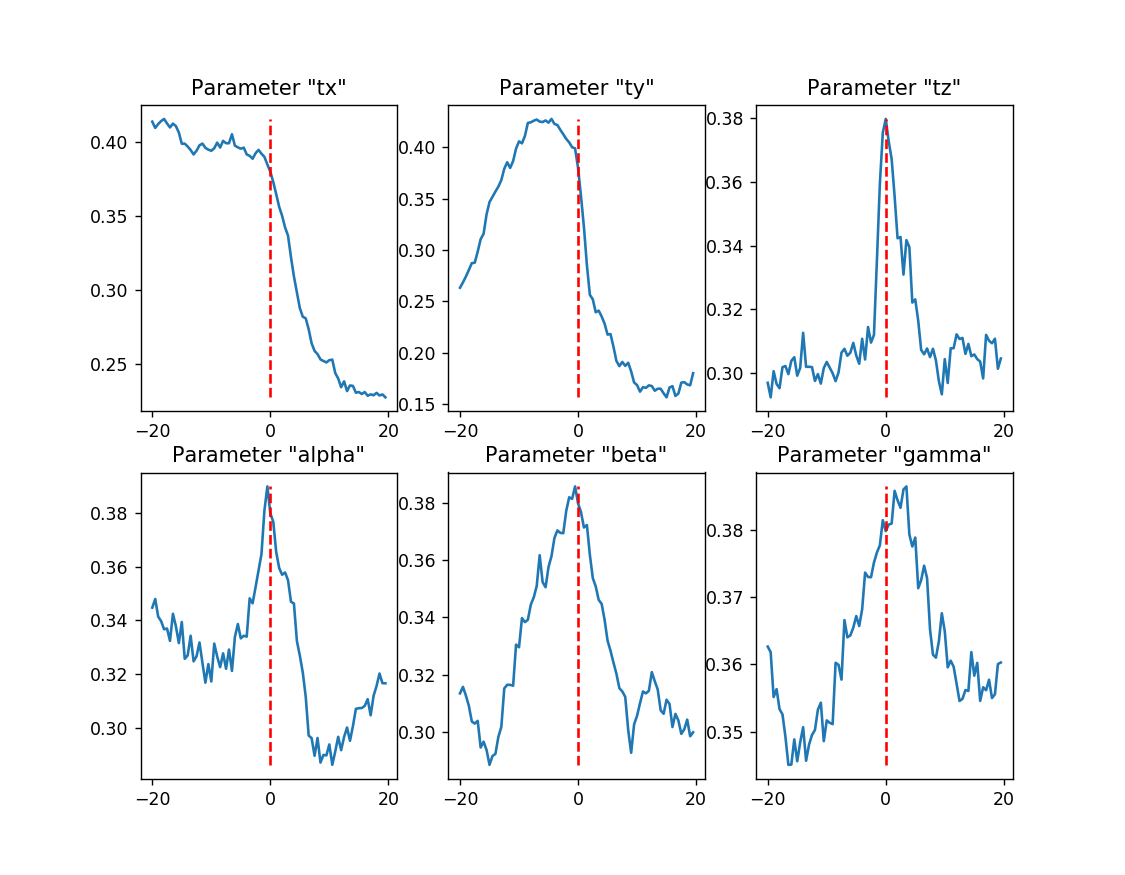

Text(0.5, 1.0, 'Parameter "gamma"')

In [19]:
# Test kriterijskih funkcij
# parametri
iCFType = 'mi'  # cc, mi
iBins = 8  # preverite vpliv števila predalov na MI
iSpan = [0.0, 255.0]  

# predobdelava 3D in 2D slik    
ct_temp = preprocess_ct(ct)
Xray_temp = preprocess_Xray(Xray)

par_names = ['tx', 'ty', 'tz', 'alpha', 'beta', 'gamma']
par_range = np.arange(-20, 20, 0.5)
oCF_plot = np.zeros([len(par_names), len(par_range)]).astype('float')

# normalizacija intenzitet v projekciji
oDRR, oDRRMask = project3DTo2D(ct_temp, Xray_temp, iStep)
ids = np.where(oDRRMask > 0)
xmin, xmax = np.min(ids[1]), np.max(ids[1])
ymin, ymax = np.min(ids[0]), np.max(ids[0])
iTemp = oDRR[ymin:ymax, xmin:xmax]
imin, imax = np.min(iTemp), np.max(iTemp)

print(imin, imax)
verbose = False

for par in range(len(par_names)):
    for idx in range(len(par_range)):
        iPar = np.zeros([len(par_names),1])
        iPar[par] = par_range[idx]
                    
        oDRR, oDRRMask = project3DTo2D(ct_temp, Xray_temp, iStep, iPar)

        if iCFType == 'mi':
            # poklici funkcijo
            ids = np.where(oDRRMask > 0)
            xmin, xmax = np.min(ids[1]), np.max(ids[1])
            ymin, ymax = np.min(ids[0]), np.max(ids[0])
            # izreži masko
            iImageI = Xray_temp['img'][ymin:ymax, xmin:xmax]
            iImageJ = oDRR[ymin:ymax, xmin:xmax]
            # normaliziraj intenzitete
            iImageI = (iImageI - iImageI.min()) / (iImageI.max() - iImageI.min()) * 255.0
            iImageJ = (iImageJ - imin) / (imax - imin) * 255.0
            # izračunaj MI
            oCF = mutualInformation(iImageI, iImageJ, iBins, iSpan)                    
        elif iCFType == 'cc':
            iImageI = Xray_temp['img']       
            iImageJ = oDRR          
            # izračunaj CC
            oCF = correlationCoefficient(iImageI, iImageJ)
        
        oCF_plot[par, idx] = oCF

        if verbose:
            print('p: {:.1f}, CF={:.2f}'.format(p, oMI)) 

fig, axs = plt.subplots(2, 3, figsize=(9, 7))
axs[0,0].plot(par_range, oCF_plot[0, :])
axs[0,0].plot([0, 0], [oCF_plot[0,:].min(), oCF_plot[0,:].max()], 'r--')
axs[0,0].set_title('Parameter "{}"'.format(par_names[0]))

axs[0,1].plot(par_range, oCF_plot[1, :])
axs[0,1].plot([0, 0], [oCF_plot[1,:].min(), oCF_plot[1,:].max()], 'r--')
axs[0,1].set_title('Parameter "{}"'.format(par_names[1]))

axs[0,2].plot(par_range, oCF_plot[2, :])
axs[0,2].plot([0, 0], [oCF_plot[2,:].min(), oCF_plot[2,:].max()], 'r--')
axs[0,2].set_title('Parameter "{}"'.format(par_names[2]))

axs[1,0].plot(par_range, oCF_plot[3, :])
axs[1,0].plot([0, 0], [oCF_plot[3,:].min(), oCF_plot[3,:].max()], 'r--')
axs[1,0].set_title('Parameter "{}"'.format(par_names[3]))

axs[1,1].plot(par_range, oCF_plot[4, :])
axs[1,1].plot([0, 0], [oCF_plot[4,:].min(), oCF_plot[4,:].max()], 'r--')
axs[1,1].set_title('Parameter "{}"'.format(par_names[4]))

axs[1,2].plot(par_range, oCF_plot[5, :])
axs[1,2].plot([0, 0], [oCF_plot[5,:].min(), oCF_plot[5,:].max()], 'r--')
axs[1,2].set_title('Parameter "{}"'.format(par_names[5]))    
#glej slike -> velik lok. optimumov, težavna optimizacija

7. Načrtajte avtomatski postopek za poravnavo 3D in 2D slik tako, da ustvarite kriterijsko funkcijo:
```python
    def criterionFcn( iPar, ct, Xray ):
        return oMP
```
ki pri podanih parametrih 3D toge preslikave `iPar` izračuna vrednost medsebojne informacije $MI$ med DRR in 2D rentgensko sliko. Optimalne vrednosti parametrov $\mathbf{p}^*$ toge preslikave določite s pomočjo simpleksne optimizacije (Vaja 6).

In [20]:
def criterionFcn(iPar, ct, Xray, cf_type='mi'):
    iStep = 1
    iBins = 8
    iSpan = [0.0, 255.0]
#     imin = -0.80841250322681901
#     imax = 13.620590454314147

    oDRR, oDRRMask = project3DTo2D(ct, Xray, iStep, iPar)

    if cf_type == 'mi':
        ids = np.where(oDRRMask>0)
        xmin, xmax = np.min(ids[1]), np.max(ids[1])
        ymin, ymax = np.min(ids[0]), np.max(ids[0])
        iImageI = Xray['img'][ymin:ymax,xmin:xmax]
        iImageJ = (oDRR[ymin:ymax,xmin:xmax] - imin) / (imax - imin) * 255.0
        return -mutualInformation(iImageI, iImageJ, iBins, iSpan)
    elif cf_type == 'cc':
        iImageI = Xray['img']
        iImageJ = oDRR        
        return correlationCoefficient(iImageI, iImageJ)

Iter    CF(p)   
   1   -0.004738
   2   -0.005488
   3   -0.008264
   4   -0.008880
   5   -0.009425
   6   -0.009432
   7   -0.009527
   8   -0.009527
   9   -0.009527
  10   -0.009529
  11   -0.009529
  12   -0.009529
  13   -0.009529
  14   -0.009529
  15   -0.009529
  16   -0.009529
  17   -0.009529
  18   -0.009529
  19   -0.009529
  20   -0.009529
  21   -0.009529
  22   -0.009529
  23   -0.009529
  24   -0.009529
  25   -0.009529
  26   -0.009529
  27   -0.009529
  28   -0.009529
Optimization terminated successfully.
         Current function value: -0.009529
         Iterations: 29
         Function evaluations: 66
Čas izračuna: 1.1 s
iPar pred poravnavo: -15
iPar po poravnavi: [-0.8412323]


<IPython.core.display.Javascript object>


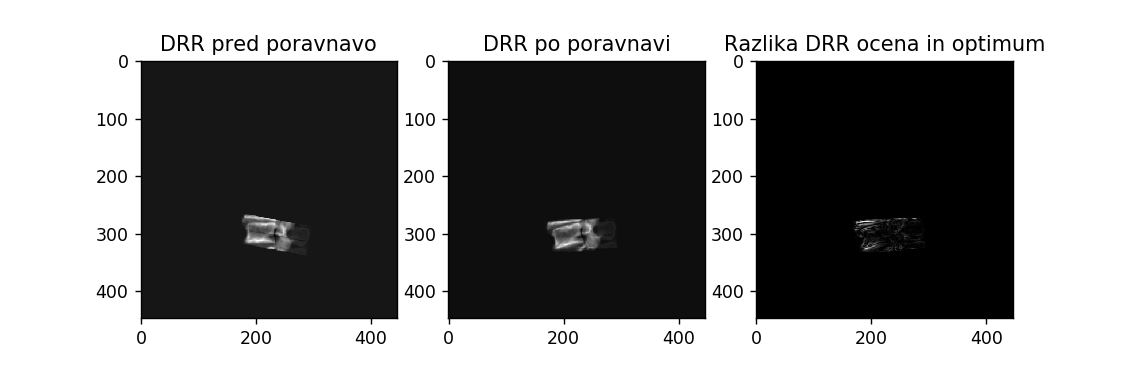

<IPython.core.display.Javascript object>


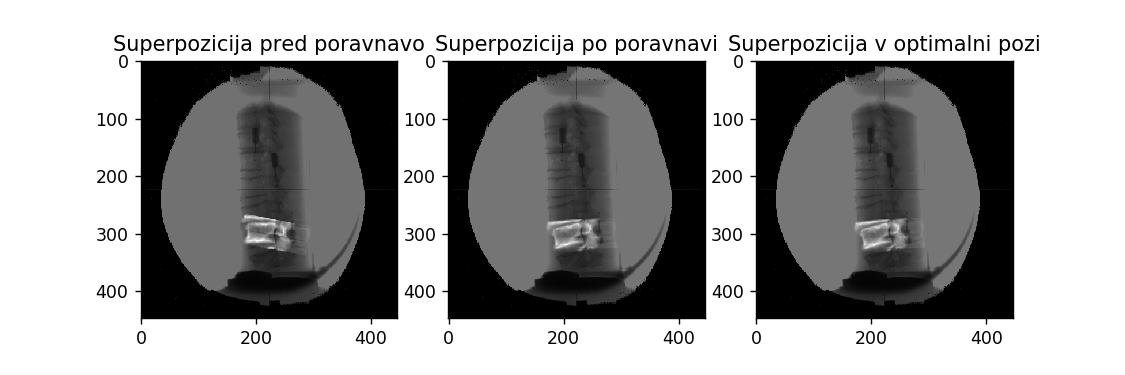

Text(0.5, 1.0, 'Superpozicija v optimalni pozi')

In [21]:
# test funkcije
cf_type = 'cc'  # mi, cc
opt_type = 'Nelder-Mead'  # Powell, Nelder-Mead
disp_iter = True

# predobdelava 3D in 2D slik    
ct_temp = preprocess_ct(ct)

Xray_temp = preprocess_Xray(Xray)    

# Optimizacija enega parametra toge preslikave: alpha
iParStart = -15
def get_full_par(iPar):
    return [0, 0, 0, iPar, 0, 0]

# # Optimizacija vseh 6 parametrov toge preslikave: tx, ty, tz, alpha, beta, gamma
# iParStart = [-5, 0, 5, -5, 5, 0]
# def get_full_par(iPar):
#     return [iPar[0], iPar[1], iPar[2], iPar[3], iPar[4], iPar[5]]

# definicija funkcije MP(p)
oCF = lambda iPar : criterionFcn(get_full_par(iPar), ct_temp, Xray_temp, cf_type=cf_type)

neval = 1
def callbackF(iPar):
    global neval
    fval = oCF(iPar)
    print('{0:4d}   {1: 3.6f}'.format(neval, fval))
    neval += 1        
if disp_iter:
    print('{0:4s}   {1:9s}'.format('Iter', ' CF(p)'))

# klic optimizacije
ts = time.clock()
# method = Nelder-Mead (simpleksna optimizacija), Powell
res = minimize(fun=oCF, x0=iParStart, method=opt_type, tol=1e-6, 
                options={'maxiter':1000, 'maxfev':5000, 'xtol':1e-6, 
                'ftol':1e-6, 'disp': disp_iter}, callback=(callbackF if disp_iter else None))
iParEnd = res.x
print('Čas izračuna: {:.1f} s'.format(time.clock()-ts))    
print('iPar pred poravnavo: {}\niPar po poravnavi: {}'.format(
      iParStart, iParEnd))

iParStart = get_full_par(iParStart)
iParEnd = get_full_par(iParEnd)

# prikaz rezultatov
oDRR_start, oDRRMask = project3DTo2D(ct_temp, Xray_temp, 3, iParStart)
oDRR_end, oDRRMask = project3DTo2D(ct_temp, Xray_temp, 3, iParEnd)
oDRR_optim, oDRRMask = project3DTo2D(ct_temp, Xray_temp, 3, np.zeros((6,1)))

# Prikaz
f1, ax1 = plt.subplots(1, 3, figsize=(9, 3))
ax1[0].imshow(oDRR_start, cmap='gray')
ax1[0].set_title('DRR pred poravnavo')

ax1[1].imshow(oDRR_end, cmap='gray')
ax1[1].set_title('DRR po poravnavi')

ax1[2].imshow(np.abs(oDRR_end-oDRR_optim), cmap='gray')
ax1[2].set_title('Razlika DRR ocena in optimum')

f2, ax2 = plt.subplots(1, 3, figsize=(9, 3))
ax2[0].imshow(2*rvlib.normalizeImage(oDRR_start, iType='range') + 
  rvlib.normalizeImage(Xray_temp['img'], iType='range'), cmap='gray')
ax2[0].set_title('Superpozicija pred poravnavo')

ax2[1].imshow(2*rvlib.normalizeImage(oDRR_end, iType='range') + 
  rvlib.normalizeImage(Xray_temp['img'], iType='range'), cmap='gray')
ax2[1].set_title('Superpozicija po poravnavi')

ax2[2].imshow(2*rvlib.normalizeImage(oDRR_optim, iType='range') + 
  rvlib.normalizeImage(Xray_temp['img'], iType='range'), cmap='gray')
ax2[2].set_title('Superpozicija v optimalni pozi')


## Dodatne naloge
Dodatne naloge naj služijo za poglobitev spretnosti programiranja, boljšemu razumevanju snovi in vsebine vaje in spoznavanju dodatnih načinov za obdelavo in analizo slik. Opravljanje dodatnih nalog je neobvezno, vendar pa priporočljivo, saj je na nek način to priprava na pisni in ustni izpit.

1. Obrazložite povezavo med medsebojno informacijo in dejansko podobnostjo 2D rentgenske in 2D projekcijskimi slikami. Katere vrednosti medsebojne informacije, višje ali nižje, odražajo dejansko podobnost med 2D rentgensko in 2D projekcijskimi oz. DRR slikami? Kolikšni sta teoretično minimalna in maksimalna vrednost medsebojne informacije?

2. Izvedite poravnavo slike `ct2` in `Xray`. Navedite vrednosti optimalnih parametrov $\mathbf{p}^*$ toge preslikave, ki rezultirajo v uspešni poravnavi 3D in 2D slik, in prikažite pripadajočo DRR sliko. Uspešnost postopka poravnave lahko preverite kot je prikazano na spodnji sliki.

3. Načrtajte poravnavo 3D CT slike `ct2` in 2D rentgenske slike `Xray` s pomočjo ročno določenih korespondenčnih točk. Zapišite model preslikave med slikama in parametre preslikave in določite model kamere, pri čemer uporabite podatke o položaju izvora in legi 2D detektorja. Optimizacijo za iskanje optimalnih parametrov izvedite na več načinov:
  *  Z *direktno linearno transformacijo* (DLT).
  *  Z nelinearno optimizacijo, pri čemer linearizirate zaprtozančni izračun koraka s $\mathbf{p} + \Delta\mathbf{p}$ in izpeljete enačbe za izračun $\Delta\mathbf{p}$.
  *  Kombinacija DLT in nato nelinearna optimizacija.

 Kateri način iskanja vrne najboljšo poravnavo 3D in 2D slik?

4. Določite napako poravnave 3D CT slike `ct2` in 2D rentgenske slike `Xray` iz prejšnjih nalog tako, da kot referenčno poravnavo uporabite podatke o legi 3D CT slike `ct`. Kot referenčne točke uporabite oglišča 3D slike. Izračunajte napako na dva načina:
  * Napaka v 3D prostoru (*ang. target registration error*: TRE) kot srednjo kvadratno napako med korespondenčnimi točkami oglišč 3D slike v referenčni legi in trenutni legi.
  * Napaka v ravnini detektorja (*ang. projected registration error*: PRE) kot srednjo kvadratno napako med korespondenčnimi točkami oglišč 3D slike v referenčni legi in trenutni legi, pri točke predhodno projicirate v 2D ravnino.

In [ ]:
def tre(ct, iPar):

    TPos = np.dot(ct['TPos'], rigidTransMatrix(ct, iPar)) 
    
    # ustvari mrezo tock oglisc 3D slike
    sz, sy, sx = ct['img'].shape
    g3x, g3y, g3z = np.meshgrid((0, sx-1), (0, sy-1), (0, sz-1), indexing='xy')
    g3 = np.vstack((g3x.flatten(), g3y.flatten(), g3z.flatten())).transpose()
    g3 = np.hstack((g3, np.ones((g3.shape[0], 1))))
    g3_ref = np.dot(g3, ct['TPos'].transpose()) 
    g3_reg = np.dot(g3, TPos.transpose())
        
    return np.linalg.norm(g3_ref[:, :3] - g3_reg[:, :3], axis=0).mean()

print('Pri translaciji tx=10 mm dobimo mTRE={:.1f} mm'.format(tre(ct, iPar=[10, 0, 0, 0, 0, 0])))
print('Pri rotaciji gamma=10 mm dobimo mTRE={:.1f} mm'.format(tre(ct, iPar=[0, 0, 0, 0, 0, 10])))

![Primer 3D2D poravnave](images/RV_8_SLO_Primer3D2DPoravnave.png)